# Binary Classification Model using CNN built from scratch.
## Making predictions.

I will try to build a Convolutional Neural Network using the `flow_from_directory` method for two classes:
    - Normal
    - Pneumonia

The CNN, built from scratch is trained using the balanced binary dataset built in previous notebooks.

## Imports

### Libraries

In [1]:
# General imports
import numpy as np
import random
import pandas as pd

# System and file management
import os
import zipfile
from imutils import paths

# Visualization Tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage.io import imread

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# jupyter:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# DICOM
import pydicom
from pydicom.filereader import dcmread

# Tensorflow
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# SKLEARN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Functions 

### Paths 

In [4]:
PATH = 'data/' # root
CSV_PATH = os.path.join(PATH,'csv') # folder with csv datasets
DICOM_PATH = os.path.join(PATH, 'pool') # folder containing all of the dicom files
JPG_PATH = os.path.join(PATH, 'pool_jpg') # folder containing all the converted jpg files
DESTINATION_PATH = os.path.join(PATH, 'sorted_balanced') # Folder where the train and test subsets will be located
MODELS_PATH = os.path.join(PATH,'model')

# Train folder
TRAIN_PATH = os.path.join(DESTINATION_PATH, 'train')
TRAIN_NORMAL_PATH = os.path.join(TRAIN_PATH, 'normal')
TRAIN_NNNP_PATH = os.path.join(TRAIN_PATH, 'nnnp')
TRAIN_PNEUMONIA_PATH = os.path.join(TRAIN_PATH, 'pneumonia')

# Validation folder
VAL_PATH = os.path.join(DESTINATION_PATH, 'validation')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'normal')
VAL_NNNP_PATH = os.path.join(VAL_PATH, 'nnnp')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'pneumonia')

# Test folder
TEST_PATH = os.path.join(DESTINATION_PATH, 'test')
TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'normal') 
TEST_NNNP_PATH = os.path.join(TEST_PATH, 'nnnp')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'pneumonia') 

### CSV

In [5]:
balanced = pd.read_csv(os.path.join(CSV_PATH, 'balanced_cxr_information.csv'))

## Model Building 

### Preprocessing images 

In [6]:
img_width, img_height = 128, 128
BS = 64
NB = 2
EPOCHS = 15

In [7]:
TRAIN_LEN = len(list(paths.list_images(TRAIN_PATH)))
VAL_LEN = len(list(paths.list_images(VAL_PATH)))
TEST_LEN = len(list(paths.list_images(TEST_PATH)))

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  # This is the source directory for training images
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=True,
        class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
        VAL_PATH,  # This is the source directory for training images
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=False,
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(img_width, img_height),  # All images will be resized to 128x128
        batch_size=BS,
        shuffle=False,
        class_mode='categorical')

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


### Network creation 

In [10]:
# Our input feature map is 512x512x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(img_width, img_height, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# max-pooling is followed by a dropout to try to avoid overfitting
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = Dropout(0.2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 1024 hidden units
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting

# Create a fully connected layer with ReLU activation and 256 hidden units
x = Dense(256, activation = "relu")(x) # Create a fully connected layer with ReLU activation and 256 hidden units
x = Dropout(0.2)(x) # Fully connected layer is followed by a dropout to try to avoid overfitting.

# Create output layer with a single node and sigmoid activation
output = layers.Dense(NB, activation='softmax')(x) # Create output layer with two nodes (binary output) and Softmax activation function


# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

#### Summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496 

#### Compilation 

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc', 'AUC'])

### Fitting

#### Setting constants: 

In [14]:
STEP_SIZE_TRAIN = TRAIN_LEN // BS
STEP_SIZE_VAL = VAL_LEN // BS
STEP_SIZE_TEST = TEST_LEN // BS

#### Fitting 

In [15]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
131/131 [==============================] - 62s 476ms/step - loss: 0.9710 - acc: 0.7238 - auc: 0.7601 - val_loss: 0.4873 - val_acc: 0.7980 - val_auc: 0.8664
Epoch 2/15
131/131 [==============================] - 64s 486ms/step - loss: 0.4369 - acc: 0.8112 - auc: 0.8830 - val_loss: 0.4280 - val_acc: 0.8103 - val_auc: 0.8868
Epoch 3/15
131/131 [==============================] - 64s 489ms/step - loss: 0.3853 - acc: 0.8378 - auc: 0.9090 - val_loss: 0.3917 - val_acc: 0.8253 - val_auc: 0.9045
Epoch 4/15
131/131 [==============================] - 63s 483ms/step - loss: 0.3609 - acc: 0.8530 - auc: 0.9205 - val_loss: 0.3826 - val_acc: 0.8382 - val_auc: 0.9147
Epoch 5/15
131/131 [==============================] - 63s 484ms/step - loss: 0.3359 - acc: 0.8623 - auc: 0.9312 - val_loss: 0.3740 - val_acc: 0.8454 - val_auc: 0.9147
Epoch 6/15
131/131 [==============================] - 63s 478ms/step - 

### Saving 

In [16]:
model.save('4_2_Model_Binary_from_directory_balanced.h5')

## Predicting the output and generating performance charts

The model is used to generate predictions over the test subset in order to obtain performance metrics.

### Accuracy and Classification Report

In [17]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps = (STEP_SIZE_TEST) + 1) 
predictions = np.argmax(predictions, axis=1)

print("Test set accuracy: " + 
      str(accuracy_score(test_generator.classes, predictions, normalize=True) * 100) 
      + "%") 

print(classification_report(test_generator.classes, predictions,
                            target_names=test_generator.class_indices.keys())) 

Test set accuracy: 89.13525498891353%
             precision    recall  f1-score   support

     normal       0.86      0.94      0.90       920
  pneumonia       0.93      0.84      0.88       884

avg / total       0.89      0.89      0.89      1804



### Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predictions))

Confusion Matrix
[[863  57]
 [139 745]]


### Training info over epochs

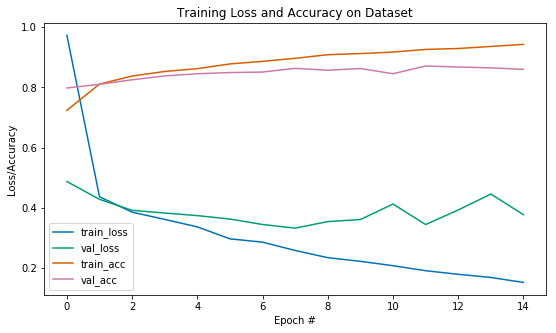

In [19]:
# plotting training data
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(9,5))
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Model_Binary_from_directory_balanced.jpg")

### ROC Curve 

In [20]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
auc = auc(fpr, tpr)

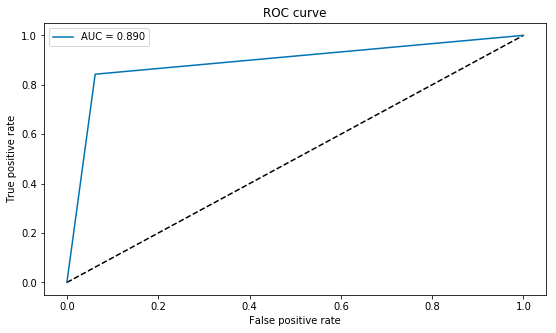

In [21]:
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(9,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("Model_Binary_from_directory_balanced_ROC.jpg")

## Conclusion 

We have been able to build a model that accurately classifies both normal and pneumonia Chest-X-Rays given a jpg image. The main setback is that the model overfits (train-acc: 94.6, val-acc: 87.61, test-acc: 88.7). We have tried to avoid overfitting by tuning the dropout layers, and have minimized it to the extent of our knowledge. You can check model performance in real life in the following notebook.